<a href="https://colab.research.google.com/github/Maryam-Afshari/thesis/blob/master/xgboost_Basel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking out the GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 14:39:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# checking out the memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
#!pip install hydroeval

# Running XGBoost model on Basel station

In [6]:
# required libraries
import numpy as np
import pandas as pd
import hydroeval as he
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# reading data 
basel = pd.read_csv('/content/drive/MyDrive/Thesis-Afshari/data/basel.csv',index_col=0)
q_basel = pd.read_csv("/content/drive/MyDrive/Thesis-Afshari/data/q_basel.csv",index_col=0)


In [9]:
# making lagged variables

# define the number of lags
TIME_STEPS = 60

#add the lagged variables for predictors to the dataframe
for i, var in enumerate(basel[["et","p","t"]]):
  for step in range(0, TIME_STEPS - 1):
    basel.insert(i*(TIME_STEPS) + 1,
                 f'{var}_lag_{TIME_STEPS - 1 - step}',
                 basel[var].shift(TIME_STEPS - 1 - step))

#remove the first TIME_STEPS - 1 rows since they will contain NA values
basel = basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)
q_basel = q_basel.iloc[TIME_STEPS - 1:,:].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if self.run_code(code, result):


# Train_test split

In [10]:
# train-test split
len_ = int(0.75 * basel.shape[0])

df_train = basel[:len_]
df_test = basel[len_:]

# x train without lagged vars
X_train = df_train[["et","t","p"]]

# x train with lagged vars
X_train_lagged = df_train.drop(columns = ["obs","datetime"], axis =1)
y_train = df_train.obs

# x test without lagged vars
X_test = df_test[["et","t","p"]]

# x test with lagged vars
X_test_lagged = df_test.drop(columns = ["obs","datetime"], axis =1)
y_test = df_test.obs


### Hyperparameter grid search

In [12]:
%%time
# Various hyper-parameters to tune for XGBoost model without input lagged variables 

xgb = XGBRegressor()
parameters = {'nthread':[1], 
              'objective':['reg:squarederror'],
              'learning_rate': [.01, .05, .1], 
              'max_depth': [7, 9], 
              'min_child_weight': [4],
              'subsample': [0.8, 0.9], 
              'colsample_bytree': [0.7, 0.9], 
              'n_estimators': [800, 1000]} 

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)


xgb_grid.fit(X_train,
         y_train)

print(f"best score for XGBoost model without lagged variables is : {xgb_grid.best_score_}")
print(f"best parameters XGBoost model without lagged variables are: {xgb_grid.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best score for XGBoost model without lagged variables is : 0.04899852875704589
best parameters XGBoost model without lagged variables are: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 800, 'nthread': 1, 'objective': 'reg:squarederror', 'subsample': 0.9}
CPU times: user 4.29 s, sys: 354 ms, total: 4.64 s
Wall time: 4min 31s


In [ ]:
%%time
# Various hyper-parameters to tune for XGBoost model with 60 input lagged variables 

xgb = XGBRegressor()
parameters = {'nthread':[1], 
              'objective':['reg:squarederror'], 
              'learning_rate': [.01, .05, .1], 
              'max_depth': [7, 9], 
              'min_child_weight': [4],
              'subsample': [0.8, 0.9], 
              'colsample_bytree': [0.7, 0.9], 
              'n_estimators': [800, 1000]} 

xgb_grid_lagged = GridSearchCV(xgb,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)


xgb_grid_lagged.fit(X_train_lagged,
         y_train)

print(f"best score for XGBoost model with 60 lagged variables is : {xgb_grid.best_score_}")
print(f"best parameters XGBoost model with 60 lagged variables are: {xgb_grid.best_params_}")

# Model

In [ ]:
# define the model for without lagged variables model
model =  xgb_grid.best_estimator_

# fit model
model.fit(X_train, y_train)

# make a prediction
yhat = model.predict(X_test)

In [ ]:
# save model and yhat
model.save_model('/content/drive/MyDrive/Thesis-Afshari/output/xgboost_basel_without_lag.model')
np.save('/content/drive/MyDrive/Thesis-Afshari/output/yhat_xgboost_basel_wihout_lag.npy',yhat, allow_pickle=True)

In [ ]:
# define the model for with 60 lagged variables model
model_lagged =  xgb_grid_lagged.best_estimator_

# fit model
model_lagged.fit(X_train_lagged, y_train)
# make a prediction
yhat_lagged = model_lagged.predict(X_test_lagged)

In [ ]:
# save model
model_lagged.save_model('/content/drive/MyDrive/Thesis-Afshari/output/xgboost_basel_with_60lag_2.model')

# save prediction with lagged 
np.save("/content/drive/MyDrive/Thesis-Afshari/output/ypred_basel_xgboost_60lag_2.npy", yhat_lagged, allow_pickle=True)


# Evaluation

In [ ]:
# evaluate pcr model using nse and kge
streamflow_pcr = q_basel.pcr[len_:]
nse_pcr = he.evaluator(he.nse, streamflow_pcr, y_test)
kge_pcr, r, alpha, beta = he.evaluator(he.kge, streamflow_pcr, y_test)
print("The nse and kge of the PCR model are {:.2} and {:.2}.".format(nse_pcr[0], kge_pcr[0]))

# evaluate the prediction using nse and kge for model with only meteorological variables
nse = he.evaluator(he.nse, yhat, y_test)

kge, r, alpha, beta = he.evaluator(he.kge, yhat, y_test)
print("The nse and kge of the xgboost model are {:.2} and {:.2}.".format(nse[0], kge[0]))

# evaluate the prediction using nse and kge for model with meteorological variables + lagged variables
nse_lag = he.evaluator(he.nse, yhat_lagged, y_test)
kge_lag, r_lag, alpha_lag, beta_lag = he.evaluator(he.kge, yhat_lagged, y_test)

print("The nse and kge of the xgboost model including lagged variables are {:.2} and {:.2}.".format(nse_lag[0], kge_lag[0]))



The nse and kge of the PCR model are 0.22 and 0.64.
The nse and kge of the xgboost model are 0.15 and 0.21.
The nse and kge of the xgboost model including lagged variables are 0.61 and 0.6.


# plots

In [ ]:
# get the desired variables to plot 
y_hat = np.load("/content/drive/MyDrive/Thesis-Afshari/output/ypred_basel_xgboost_60lag_2.npy") 
streamflow_pcr = q_basel.pcr[len_:]
obs = y_test 
df_test['datetime'] =  pd.to_datetime(df_test['datetime'], infer_datetime_format=True)
date = df_test.datetime 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


No handles with labels found to put in legend.


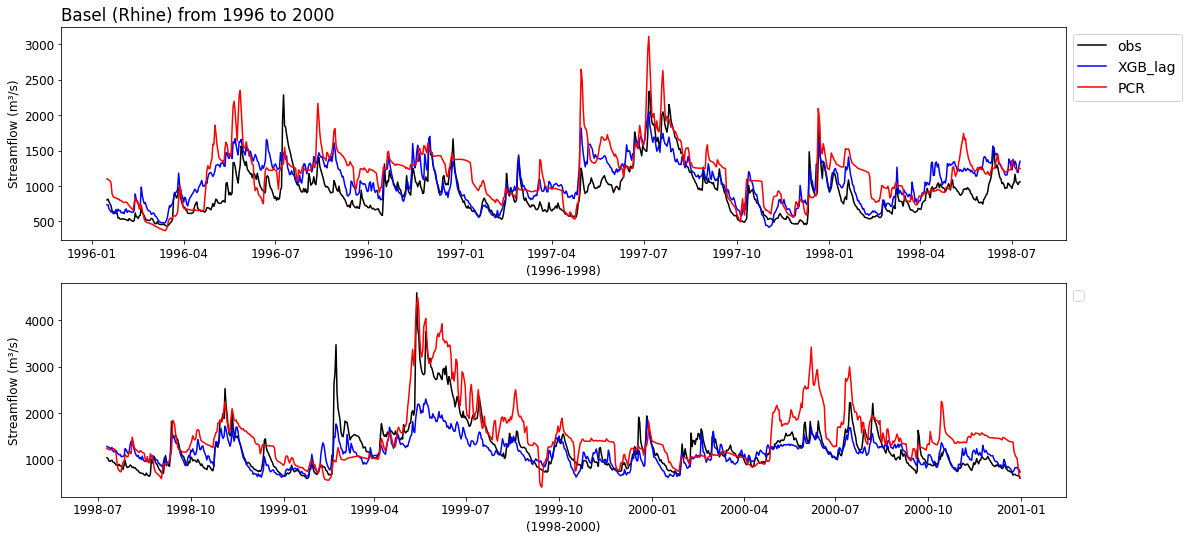

In [ ]:
# get the len of variables to plot 
len_ = int(0.5 * y_test.shape[0])
len_

# years to plot
date_1 = date[:len_]
date_2 = date[len_:]

# dividing variables to two years
actual_1 = y_test[:len_]
actual_2 = y_test[len_:]

predicted_1 = y_hat[:len_]
predicted_2 = y_hat[len_:]

pcr_prediction_1 = streamflow_pcr[:len_]
pcr_prediction_2 = streamflow_pcr[len_:]

# plot the variables
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(18, 18*2/(1+10**0.5)))
ax1.plot(date_1, actual_1, "black",label ="obs")
ax1.plot(date_1, predicted_1, "b", label = "XGB_lag")
ax1.plot(date_1, pcr_prediction_1,"r", label = "PCR")

ax2.plot(date_2, actual_2,"black")
ax2.plot(date_2, predicted_2,"b")
ax2.plot(date_2, pcr_prediction_2, "r")

# tweak the axes
ax1.set_title('Basel (Rhine) from 1996 to 2000', loc ="left")
ax1.set_ylabel('Streamflow (m³/s)', fontsize = 12) 
ax2.set_ylabel('Streamflow (m³/s)', fontsize = 12)
ax1.set_xlabel('(1996-1998)', fontsize =12)
ax2.set_xlabel('(1998-2000)', fontsize =12)


for ax in (ax1, ax2):
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(axis='x', labelsize=12)
  ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

  

plt.savefig("/content/drive/MyDrive/Thesis-Afshari/figures/1996-2001_basel_XGB_lag.png")

In [ ]:
# save the pcr prediction 
streamflow_pcr = q_basel.pcr[len_:]
np.save("/content/drive/MyDrive/Thesis-Afshari/output/yaht_pcr_basel.npy", streamflow_pcr , allow_pickle=True )

# save the y_test

np.save("/content/drive/MyDrive/Thesis-Afshari/output/y_test_XGB_basel.npy", y_test , allow_pickle=True )